In [12]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

import roma
import kornia
import utils.colmap as colmap_utils
import utils.opt as opt_utils

from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

from utils.umeyama import umeyama
from utils.metric_torch import evaluate_auc, evaluate_pcd

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [13]:
torch._dynamo.config.accumulated_cache_size_limit = 512

def run_VGGT(images, device, dtype):
    # images: [B, 3, H, W]

    # Run VGGT for camera and depth estimation
    model = VGGT()
    _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
    model.eval()
    model = model.to(device).to(dtype)
    print(f"Model loaded")

    with torch.no_grad():
        predictions = model(images.to(device, dtype), verbose=True)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])
        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = predictions['depth'].squeeze(0).cpu().numpy()
        depth_conf = predictions['depth_conf'].squeeze(0).cpu().numpy()
    
    return extrinsic, intrinsic, depth_map, depth_conf

In [14]:
# Get image paths and preprocess them
data_dir = "../data/MipNeRF360/flowers"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
image_dir = os.path.join(data_dir, "images")
scene = os.path.basename(data_dir)

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

In [15]:
images_gt_keys = list(images_gt.keys())
random.shuffle(images_gt_keys)
images_gt_updated = {id: images_gt[id] for id in list(images_gt_keys)}
image_path_list = [os.path.join(image_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]

img_load_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, img_load_resolution)
original_coords = original_coords.to(device)

In [16]:
extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(images, device, dtype)
torch.cuda.empty_cache()

Model loaded
Running patch embedding


Running attention: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Running camera head
Running depth head
Running point head
Running track head


In [17]:
fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

    --  Umeyama Scale:  6.20145490893783
    --  Umeyama Rotation: 
 [[-0.49476862 -0.03852402  0.86817045]
 [-0.27365954  0.95509726 -0.11357673]
 [-0.82481182 -0.29377732 -0.48309461]]
    --  Umeyama Translation: 
 [[-3.2881005 ]
 [ 1.10607704]
 [ 1.42579584]]
    --  Pair Rot   Error (Deg) of Vanilla:       3.05
    --  Pair Trans Error (Deg) of Vanilla:       3.36
    --  AUC at 30: 0.8731


## 1. Calculate Tracking

In [58]:
target_match_dir = f"./matches_{scene}.pt"
if os.path.exists(target_match_dir):
    print(f"Found existing matches at {target_match_dir}, loading it")
    match_outputs = torch.load(target_match_dir)
else:
    max_query_pts = 4096 if len(images) < 500 else 2048
    match_outputs = opt_utils.extract_matches(extrinsic, intrinsic, images, base_image_path_list, max_query_pts, err_range=60)
    match_outputs["original_width"] = images.shape[-1]
    match_outputs["original_height"] = images.shape[-2]
    # torch.save(match_outputs, target_match_dir)
    # print(f"Saved matches to {target_match_dir}")

Total candidate image pairs found:  1907


Matching image pairs...: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


## 2. Optimize Pose

In [59]:
def pose_optimization(match_outputs, 
                      extrinsic, 
                      intrinsic, 
                      images, 
                      depth_map, 
                      depth_conf, 
                      base_image_path_list, 
                      device='cuda',
                      lr_base=None,
                      lr_end=None,
                      min_thr=50.0,
                      max_thr=200.0,
                      lambda_3d=0.1,
                      lambda_epi=1.0,
                      niter=300,
                      target_scene_dir=None,
                      shared_intrinsics=True):
    
    torch.cuda.empty_cache()
    
    if lr_base is None or lr_end is None:
        lr_base, lr_end = opt_utils.get_default_lr(match_outputs["epipolar_err"])
    
    with torch.no_grad():
        imsizes = torch.tensor([images.shape[-1], images.shape[-2]]).float()
        diags = torch.norm(imsizes)
        min_focals = 0.25 * diags  # diag = 1.2~1.4*max(W,H) => beta >= 1/(2*1.2*tan(fov/2)) ~= 0.26
        max_focals = 10 * diags

        qvec = roma.rotmat_to_unitquat(torch.tensor(extrinsic[:, :3, :3]))
        tvec = torch.tensor(extrinsic[:, :3, 3])
        log_sizes = torch.zeros(len(qvec))

        pps = torch.tensor(intrinsic[:, :2, 2]) / imsizes[None, :2]  # default principal_point would be (0.5, 0.5)
        base_focals = torch.tensor((intrinsic[:, 0, 0] + intrinsic[:, 1, 1]) / 2)

        # intrinsics parameters
        if shared_intrinsics:
            # Optimize a single set of intrinsics for all cameras. Use averages as init.
            confs = depth_conf.mean(axis=(1, 2))
            weighting = torch.tensor(confs / confs.sum())
            pps = weighting @ pps
            pps = pps.view(1, -1)
            focal_m = weighting @ base_focals
            log_focals = focal_m.view(1).log()
        else:
            log_focals = base_focals.log()

        corr_points_i = match_outputs["corr_points_i"].clone()
        corr_points_j = match_outputs["corr_points_j"].clone()
        corr_weights = match_outputs["corr_weights"].clone()
        num_matches = match_outputs["num_matches"]
        indexes_i = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_i"]]
        indexes_j = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_j"]]
        imsizes = imsizes.to(corr_points_i.device)
        
    qvec = qvec.to(device)
    tvec = tvec.to(device)
    log_sizes = log_sizes.to(device)
    min_focals = min_focals.to(device)
    max_focals = max_focals.to(device)
    imsizes = imsizes.to(device)
    pps = pps.to(device)
    log_focals = log_focals.to(device)

    corr_points_i = corr_points_i.to(device)
    corr_points_j = corr_points_j.to(device)
    corr_weight_valid = corr_weights.to(device)
    corr_weight_valid = corr_weight_valid**(0.5)
    corr_weight_valid /= corr_weight_valid.mean()

    params = [{
        "params": [
            qvec.requires_grad_(True), 
            tvec.requires_grad_(True), 
            log_sizes.requires_grad_(True),
            log_focals.requires_grad_(True),
            pps.requires_grad_(True)
        ],
        "name": ["qvec", "tvec", "log_sizes", "log_focals", "pps"],
    }]

    optimizer = torch.optim.Adam(params, lr=1, weight_decay=0, betas=(0.9, 0.9))
     ##### Get all the pruning thresholds #####
    thr_list = torch.linspace(
        min_thr, max_thr, niter, device=device
    )  # (num_prune_steps,)
    thr_list = thr_list.flip(0)  # (num_prune_steps,) from large to small
    thr_list = thr_list.tolist()  # list

    loss_list = []
    for iter in tqdm(range(niter or 1), desc="Pose Optimization..."):

        repeat_cnt = 1 if len(qvec) else shared_intrinsics
        
        K, (w2cam, cam2w) = opt_utils.make_K_cam_depth(log_focals.repeat(repeat_cnt), pps.repeat(repeat_cnt, 1), tvec, qvec, min_focals, max_focals, imsizes)
        
        alpha = (iter / niter)
        lr = opt_utils.cosine_schedule(alpha, lr_base, lr_end)
        opt_utils.adjust_learning_rate_by_lr(optimizer, lr)
        optimizer.zero_grad()

        Ks_i = K[indexes_i]
        Ks_j = K[indexes_j]
        w2cam_i = w2cam[indexes_i]
        w2cam_j = w2cam[indexes_j]

        loss = 0.0

        # batchify the computation to avoid OOM
        P_i = Ks_i @ w2cam_i
        P_j = Ks_j @ w2cam_j
        Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
        err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i, corr_points_j, Fm, squared=False, eps=1e-08)
        loss = (err * corr_weight_valid.squeeze(-1)).sum() / (corr_weight_valid > 0).sum() * lambda_epi

        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        corr_weight_valid[corr_weight_valid > thr_list[iter]] = 0.0

        # plot error histogram
        if iter == 0 and target_scene_dir is not None:
            plt.style.use("seaborn-v0_8-whitegrid")
            plt.figure(figsize=(10, 5))
            plt.hist(err.reshape(-1).detach().cpu().numpy(), bins=100, color='blue', alpha=0.7)
            plt.xlabel('Epipolar Error')
            plt.ylabel('Frequency')
            plt.title('Histogram of Epipolar Errors (Before Optimization)')
            # plt.savefig(f"{target_scene_dir}/epipolar_error_hist_before.png")
            # plt.close()
    
    if target_scene_dir is not None:
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss Value')
        plt.title(f'Loss Curve, final loss={loss_list[-1]:.4f}')
        plt.show()
        plt.savefig(f"{target_scene_dir}/loss_curve_pose_opt.png")

    
    output_extrinsic = w2cam[:, :3, :4].detach().cpu().numpy()
    output_intrinsic = K[:, :3, :3].detach().cpu().numpy()

    return output_extrinsic, output_intrinsic

In [60]:
print(match_outputs["epipolar_err"])

7.987223148345947


Pose Optimization...: 100%|██████████| 300/300 [00:07<00:00, 40.15it/s]


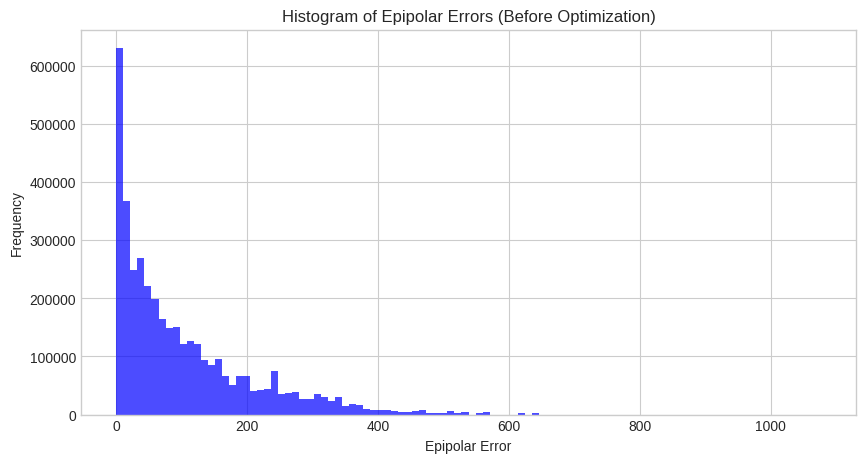

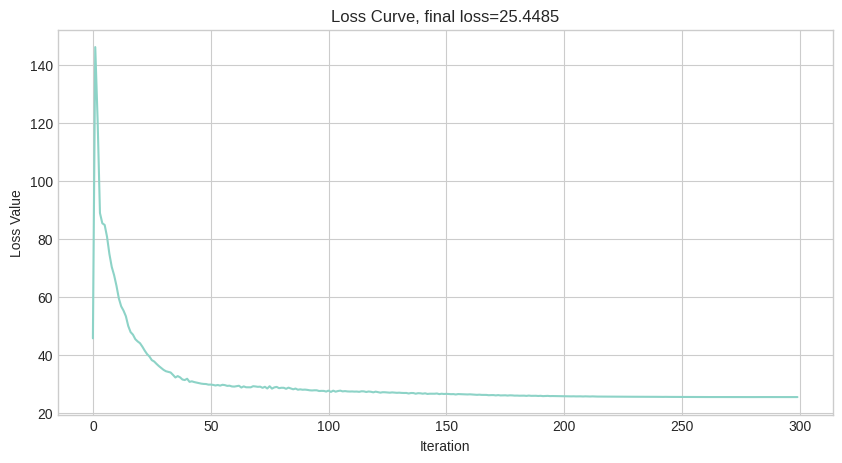

<Figure size 640x480 with 0 Axes>

In [61]:
extrinsic_, intrinsic_ = pose_optimization(
    match_outputs, extrinsic, intrinsic, images, depth_map, depth_conf,
    base_image_path_list, target_scene_dir='./', shared_intrinsics=True,
)

In [62]:
# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(extrinsic_), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic_[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic_[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

    --  Umeyama Scale:  5.636894633560796
    --  Umeyama Rotation: 
 [[-0.48733393 -0.04440629  0.87208582]
 [-0.27168738  0.95684702 -0.10310047]
 [-0.82987446 -0.28717907 -0.47836868]]
    --  Umeyama Translation: 
 [[-2.99368231]
 [ 0.98672547]
 [ 1.26949855]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.17
    --  Pair Trans Error (Deg) of Vanilla:       1.06
    --  AUC at 30: 0.9692
